**Pathlines_mf6_mp7** w04b

In [1]:
import os; import sys; from pathlib import Path; from pprint import pformat ; from shutil import copytree ; import matplotlib as mpl ; 
import matplotlib.pyplot as plt ; import numpy as np ; import pandas as pd; import shapefile ; import flopy ; from os.path import join; import csv 
import numpy.ma as ma

In [2]:
sim_ws = Path('E:\\15_REPOS\\00_BETAMI\\94_floPy\\04_Path_w04b')  ; sim_ws.mkdir(exist_ok=True)  
sim_name = model_name   = "ex01_mf6" ; exe_name = "mf6"           ; output_folder = ws = workspace = sim_ws  

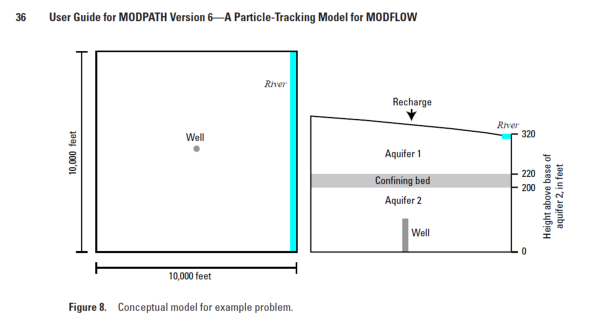

In [3]:
fig = plt.figure(figsize=(40, 4))                 
ax = fig.add_subplot(111, aspect="equal" )
image = plt.imread('E:/15_REPOS/00_BETAMI/00_MF6/_aux/23_floPy_w04a.PNG')          ; ax.imshow(image) ; ax.axis('off') ; plt.show()

In [4]:
nper, nstp, perlen, tsmult = 1, 1, 1.0, 1.0    ; nlay, nrow, ncol = 3, 15, 30                           ; delr = 350 ;  delc = 700
top = 400.0 ; botm = [220.0, 200.0, 0.0]       ; kh = [50.0, 0.001, 20.0] ; kv = [10.0, 0.01, 20.0]     ; laytyp = [1, 0, 0]
wel_loc = (2, 10, 9) ; wel_q = -150000.0       ; riv_h = 320.0; riv_z = 317.0 ; riv_c = 1.0e5           ; rch = 0.005  
filename1="ex01a.pg1.sloc" ; filename2="ex01a.pg2.sloc"    ; shape3d = (nlay, nrow, ncol)               ; pdd = (perlen, nstp, tsmult)

In [5]:
wd = [(wel_loc, wel_q)]                                            ; riv_spd = []     # ; iu_cbc = 130
for i in range(nrow):      riv_spd.append([(0, i, ncol - 1), riv_h, riv_c, riv_z])
head_filerecord = f"{sim_name}.hds"  ; budget_filerecord = f"{sim_name}.cbc"
model_nam_file = "{}.nam".format(sim_name)

sim = flopy.mf6.MFSimulation   (sim_name=sim_name, exe_name="mf6", version="mf6", sim_ws=ws)
flopy.mf6.ModflowTdis(sim, time_units="DAYS", nper=nper, perioddata=[pdd])
gwf = flopy.mf6.ModflowGwf    (sim, modelname = sim_name, model_nam_file=model_nam_file, save_flows=True)
flopy.mf6.ModflowIms     (sim ,complexity="SIMPLE" ,outer_dvclose=1e-6 ,inner_dvclose=1e-6 ,rcloserecord=1e-6)
flopy.mf6.ModflowGwfdis  (gwf ,nlay=nlay ,nrow=nrow ,ncol=ncol ,length_units="FEET" ,delr=delr ,delc=delc ,top=top ,botm=botm)
flopy.mf6.ModflowGwfic   (gwf ,strt=top)
flopy.mf6.ModflowGwfnpf  (gwf, icelltype=laytyp, k=kh, k33=kv,save_specific_discharge=True)
flopy.mf6.ModflowGwfrcha (gwf, recharge=rch)
flopy.mf6.ModflowGwfwel  (gwf, maxbound=1, stress_period_data={0: wd})
flopy.mf6.ModflowGwfriv  (gwf, stress_period_data={0: riv_spd})
flopy.mf6.ModflowGwfoc   (gwf,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,
                          saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])
sim.write_simulation(silent=True) ;sim.run_simulation(silent=True,report=False)

(True, [])

In [6]:
rd2 = pd.DataFrame(riv_spd) ; rd3 = rd2.rename(columns = lambda x : 'a'  + str(x)) ; rd4 = rd3['a0']; rd5 = rd4.tolist() ; rd6 = pd.DataFrame(rd5)     
rd7 = rd6.rename(columns = lambda x : 'ab' + str(x)) ; df = pd.concat([rd3[:], rd7[:]], axis=1)   ; df.to_csv (sim_ws / "01_riv_spd.csv") ; df.head(); 

In [7]:
vvv   = [(0,0,2),(0,1,2),(0,2,2),(0,3,2),(0,17,2),(0,18,2),(0,19,2),(0,20,2)] ; 
part1 = flopy.modpath.ParticleData(vvv, drape=1, structured=True, particleids=[1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008])  
pg1 =flopy.modpath.ParticleGroup(particledata=part1,filename=filename2) ;particlegroups=[pg1] ;np.savetxt(sim_ws/"02_path_IN.csv",vvv,delimiter=",")

In [8]:
exe_name = "mp7"                  ; zone3 = np.ones((nrow, ncol), dtype=np.int32)   ;  zone3[wel_loc[1:]] = 2  ; zones = [0, 0, zone3]
mp    = flopy.modpath.Modpath7    (modelname=sim_name + "_mp", flowmodel=gwf, exe_name=exe_name, model_ws=ws)
mpbas = flopy.modpath.Modpath7Bas (mp, porosity=0.1)
mpsim = flopy.modpath.Modpath7Sim (mp, simulationtype="combined"  ,trackingdirection ="forward",weaksinkoption ="pass_through",
                                   weaksourceoption="pass_through",budgetoutputoption="summary",stoptimeoption ="extend",
                                   zonedataoption="on"    ,zones=zones  ,particlegroups = particlegroups)   # zones  # particlegroups
mp.write_input() ; mp.run_model(silent=True, report=False)

(True, [])

In [9]:
def get_nodes(locs):
    nodes = []
    for k, i, j in locs: nodes.append(k * nrow * ncol + i * ncol + j)
    return nodes
nodew   = get_nodes([wel_loc]) ; cellids = gwf.riv.stress_period_data.get_data()[0]["cellid"]    ; nodesr  = get_nodes(cellids)
fpth = os.path.join(ws, model_name + "_mp.mppth")                  ; pp = flopy.utils.PathlineFile(fpth)
pw0 = pp.get_destination_pathline_data(nodew, to_recarray=True)    ; pr1 = pp.get_destination_pathline_data(nodesr, to_recarray=True)

In [10]:
head = flopy.utils.HeadFile(workspace / f"{sim_name}.hds") ; heads = head.get_data()  ; ss =np.max(heads) - np.min(heads)
sim = flopy.mf6.MFSimulation.load(sim_ws = sim_ws ,exe_name = exe_name ,verbosity_level = 0) 
cobj = gwf.output.budget()  ; spd = cobj.get_data(text="DATA-SPDIS")[0]     
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spd, gwf)

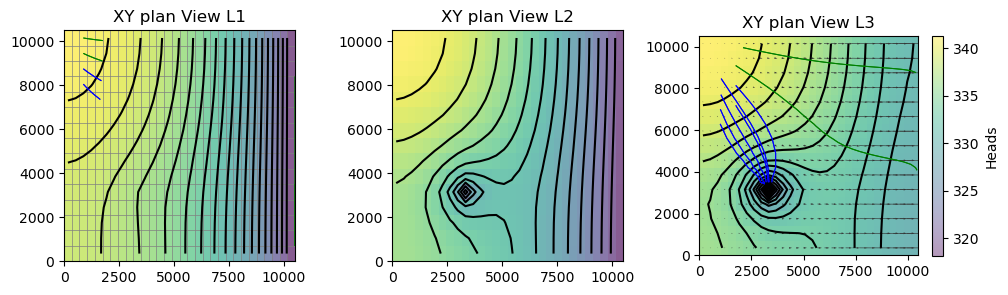

In [16]:
fig = plt.figure(figsize=(12, 3))                             
ax = fig.add_subplot(131, aspect="equal")            ; mm = flopy.plot.PlotMapView(model=gwf, ax=ax)  ;ll=0  ; mm.plot_grid(lw=0.5)
mm.contour_array(heads[ll], levels=np.arange(np.min(heads[ll]), np.max(heads[ll]), ss/20),colors = 'black')  ; ax.set_title("XY plan View L1")
mm.plot_pathline(pw0,layer=ll,colors='blue',lw=0.75) ; mm.plot_pathline(pr1,layer=ll,colors='green',lw=0.75) ;hdd=mm.plot_array(heads[ll],alpha=0.4)
ax = fig.add_subplot(132, aspect="equal")            ; mm = flopy.plot.PlotMapView(model=gwf, ax=ax)  ;ll=1  
mm.contour_array(heads[ll], levels=np.arange(np.min(heads[ll]), np.max(heads[ll]), ss/20),colors = 'black')  ; ax.set_title("XY plan View L2")
mm.plot_pathline(pw0,layer=ll,colors='blue',lw=0.75) ; mm.plot_pathline(pr1,layer=ll,colors='green',lw=0.75) ;hdd=mm.plot_array(heads[ll],alpha=0.4)
ax = fig.add_subplot(133, aspect="equal")            ; mm = flopy.plot.PlotMapView(model=gwf, ax=ax)  ;ll=2  
mm.contour_array(heads[ll], levels=np.arange(np.min(heads[ll]), np.max(heads[ll]), ss/20),colors = 'black')  ; ax.set_title("XY plan View L3")
mm.plot_pathline(pw0,layer=ll,colors='blue',lw=0.75) ; mm.plot_pathline(pr1,layer=ll,colors='green',lw=0.75) ;hdd=mm.plot_array(heads[ll],alpha=0.4)
cb = plt.colorbar(hdd, shrink=0.95)                     ; cb.set_label("Heads")  ; mm.plot_vector(qx, qy, normalize=False, color=".2") ; plt.show()

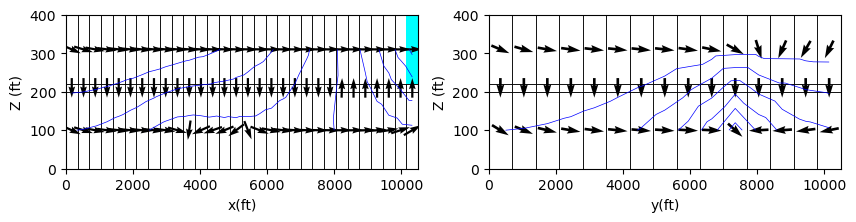

In [12]:
fig = plt.figure(figsize=(10, 2))  ; levels=np.arange(np.min(heads[ll]), np.max(heads[ll]), ss/10) 
ax = fig.add_subplot(121)          ; xs = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"row": 8})      ; xs.plot_grid(lw=0.5, color="black")
ax.set_xlabel("x(ft)")             ; ax.set_ylabel("Z (ft)") ; xs.plot_bc("RIV", color="cyan")
xs.contour_array(heads,levels=levels,linewidths=0.5,colors="b",linestyles="solid"); xs.plot_vector(qx,qy,qz,normalize=True)
ax = fig.add_subplot(122)          ; xs = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"column": 8})   ; xs.plot_grid(lw=0.5, color="black") 
ax.set_xlabel("y(ft)")             ; ax.set_ylabel("Z (ft)") ; xs.plot_bc("RIV", color="cyan")          ; xs.plot_vector(qx,qy,qz,normalize=True)    
xs.contour_array(heads,levels=levels,linewidths=0.5,colors="b",linestyles="solid")  
# mm.plot_pathline(pw0,layer=0,colors='blue',lw=0.75) ; mm.plot_pathline(pr1,layer=0,colors='green',lw=0.75)
plt.show()